In [1]:
%load_ext autoreload
%autoreload 1
%aimport resource_networks
%aimport network_manipulation 


from resource_networks import *
from network_manipulation import *

import matplotlib.pyplot as plt
import matplotlib
plt.rcParams["figure.figsize"] = (10, 7)
plt.rcParams["axes.grid"] = True
plt.rcParams["font.size"] = 12
%matplotlib notebook

import scipy
# import plotly.graph_objs as go
# import plotly.express as px

In [2]:
def flow_func_in_area(G: ResourceDiGraph, area_marker: str) -> np.ndarray:
    M = G.adjacency_matrix
    n = len(M)
    q = sp.symarray('q', n)
    flow_func = np.zeros((n, n), dtype=object)
    for i in range(n):
        if area_marker[i] == '+':
            flow_func[i] = M[i]
        else:
            r_out = M[i].sum()
            flow_func[i] = q[i]*M[i] / r_out 
    return flow_func

def func_in_area(G: ResourceDiGraph, area_marker: str) -> sp.Matrix:
    flow = flow_func_in_area(G, area_marker)
    q = sp.symarray('q', len(G))
#     for it in q, flow.sum(axis=0), flow.sum(axis=1):
#         display(sp.Matrix(it))
    return sp.Matrix(q + flow.sum(axis=0) - flow.sum(axis=1))

def all_variants(G: ResourceDiGraph) -> Dict[str, sp.Matrix]:
    n = len(G)
    res = dict.fromkeys(map(lambda x: ''.join(x), itertools.product('-+', repeat=n)))
    for key in res.keys():
        res[key] = func_in_area(G, key)
    return res

In [3]:
def plot_3d_resource(G, W, n, normalize=False, length=1):
    Q = np.asarray(np.meshgrid(np.linspace(0, W, n), np.linspace(0, W, n)))
    Q = Q[:,Q.sum(axis=0) <= W]
    Q = np.concatenate((Q, (W - Q.sum(axis=0)).reshape((1,-1))), axis=0)
    SQ = np.apply_along_axis(G.S, 0, Q)
    dSQ = SQ - Q
    norm = matplotlib.colors.Normalize()
    colormap = matplotlib.cm.jet
    colors = np.linalg.norm(dSQ, axis=0)
    ax = plt.figure(figsize=(7, 5)).add_subplot(projection='3d')
    ax.view_init(elev=33, azim=45)
    ax.quiver(*Q, *dSQ, arrow_length_ratio=0.2, color=colormap(norm(colors)),
             normalize=normalize, length=length)

In [4]:
G = ResourceDiGraph(nx.from_numpy_array(np.array([
    [0, 4, 5],
    [1, 0, 4],
    [3, 0, 0]
]), create_using=nx.DiGraph))
sim = G.run_simulation([20, 2, 1])
plot_simulation(G, sim)

interactive(children=(IntSlider(value=0, description='№ of iteration', max=29), Output()), _dom_classes=('widg…

In [5]:
W = sp.symbols('W')
q = sp.symarray('q', len(G))

vars_ = all_variants(G)
for k, v in vars_.items():
#     v.jacobian(q)
    display(k, v)

# display(sp.Matrix(flow_func_in_area(G, '--+')))
# f = func_in_area(G, '--+').subs(q[2], W - q[0] - q[1])

# res = f.jacobian((q[0], q[1], W))
# res.eigenvals()

'---'

Matrix([
[      q_1/5 + q_2],
[          4*q_0/9],
[5*q_0/9 + 4*q_1/5]])

'--+'

Matrix([
[                  q_1/5 + 3],
[                    4*q_0/9],
[5*q_0/9 + 4*q_1/5 + q_2 - 3]])

'-+-'

Matrix([
[          q_2 + 1],
[4*q_0/9 + q_1 - 5],
[      5*q_0/9 + 4]])

'-++'

Matrix([
[                4],
[4*q_0/9 + q_1 - 5],
[5*q_0/9 + q_2 + 1]])

'+--'

Matrix([
[q_0 + q_1/5 + q_2 - 9],
[                    4],
[          4*q_1/5 + 5]])

'+-+'

Matrix([
[  q_0 + q_1/5 - 6],
[                4],
[4*q_1/5 + q_2 + 2]])

'++-'

Matrix([
[q_0 + q_2 - 8],
[      q_1 - 1],
[            9]])

'+++'

Matrix([
[q_0 - 5],
[q_1 - 1],
[q_2 + 6]])

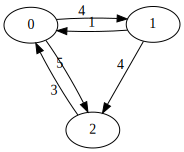

In [6]:
G.plot()

In [7]:
func_in_area(G, '--+').jacobian(q).eigenvals()

{-2*sqrt(5)/15: 1, 2*sqrt(5)/15: 1, 1: 1}

<IPython.core.display.Javascript object>


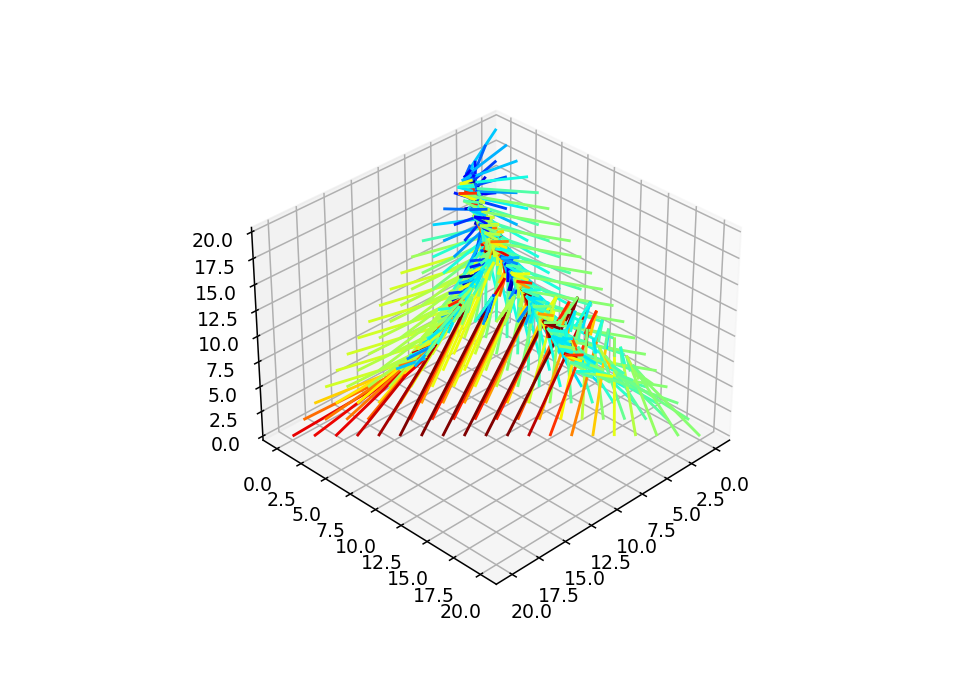

In [8]:
plot_3d_resource(G, W=20, n=20, normalize=False, length=1)

$$S(q) - q = 0$$

In [55]:
n = 2
A = sp.symarray('a', (n,n))
b = sp.symarray('b', (n,)).reshape((-1, 1))
x = sp.Matrix(sp.symarray('x', (n+1,)))
A_ = np.block([[A, b], 
               [np.zeros((1, n), dtype=int), 1]])
A_ = sp.Matrix(A_)
A_

Matrix([
[a_0_0, a_0_1, b_0],
[a_1_0, a_1_1, b_1],
[    0,     0,   1]])

In [56]:
sp.linsolve([A_ - sp.eye(n+1), sp.zeros(n+1, 1)])

{(tau0*(a_0_1*b_1 - a_1_1*b_0 + b_0)/(a_0_0*a_1_1 - a_0_0 - a_0_1*a_1_0 - a_1_1 + 1), tau0*(-a_0_0*b_1 + a_1_0*b_0 + b_1)/(a_0_0*a_1_1 - a_0_0 - a_0_1*a_1_0 - a_1_1 + 1), tau0)}

In [49]:
(A_ - sp.eye(n+1))@x

Matrix([
[a_0_1*x_1 + a_0_2*x_2 + b_0*x_3 + x_0*(a_0_0 - 1)],
[a_1_0*x_0 + a_1_2*x_2 + b_1*x_3 + x_1*(a_1_1 - 1)],
[a_2_0*x_0 + a_2_1*x_1 + b_2*x_3 + x_2*(a_2_2 - 1)],
[                                                0]])